# State Assignment Using Decision Trees
Explore doing state assignment with decision trees. 

- Handle small classes by combining classes.
- Do crossvalidation
- Explore sensitivity to perturbations in the data

In [2]:
import init
from common import constants as cn
from common.data_provider import DataProvider
from common import transform_data
from common_python.statistics import empirical_distribution_generator, density, multiple_density, util_statistics
from common_python.plots import util_plots


from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Generate Classification Data

1. T0 is eliminated
1. Normoxia is combined with Resuscitation (because of small number of Normoxia)
1. Perfectly correlated genes are combined

In [7]:
provider = DataProvider()
provider.do()

In [14]:
# Geenrate the feature data
def makeFeatureDF(provider):
    df_Xdata = transform_data.aggregateGenes(provider=provider)
    df_Xdata = df_Xdata.T
    df_Xdata = df_Xdata.drop(index="T0")
    data_features = df_Xdata.columns
    df_Xdata.columns = range(len(data_features))
    return df_Xdata

def makeFeatureColumns(provider):
    df_X = transform_data.aggregateGenes(provider=provider)
    df_X = df_X.T
    return df_X.columns.tolist()


df_Xdata = makeFeatureDF(provider)
df_Xdata.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


There are only two Noroxia states, one of which is a reference state. So, for the class data, we combine
Noroxia with Resusitation.

In [9]:
# Prepare the state data
def makeClassSer(provider):
    ser_state = provider.df_stage_matrix[cn.STAGE_NAME]
    ser_state = ser_state.drop(index="T0")
    ser_state = ser_state.copy()
    ser_state[ser_state == 'Normoxia'] = 'Resuscitation'
    # Create converter from state name to numeric index
    states = ser_state.unique()
    state_dict = {k: v for v, k in enumerate(states)}
    ser = ser_state.apply(lambda k: state_dict[k] )
    return ser
ser_Ydata = makeClassSer(provider)

In [10]:
ser_Ydata.head()

timepoint
T1    0
T2    1
T3    1
T4    1
T5    1
Name: name, dtype: int64

## Common Codes

In [7]:
# View the tree
def viewTree(df_X, ser_Y):
    dtree = tree.DecisionTreeClassifier(criterion = "entropy")
    dtree = dtree.fit(df_X, ser_Y)
    with open("dtree.dot", 'w') as fd:
        dotfile = tree.export_graphviz(dtree, out_file = fd, feature_names = df_X.columns)
    !dot -Tpng dtree.dot -o dtree.png

## sklearn Decision Trees

In [8]:
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([1.        , 0.93333333, 1.        , 0.93333333, 0.93333333,
       0.86666667, 0.93333333, 1.        , 1.        , 1.        ])

In [9]:
type(iris.data)

numpy.ndarray

In [10]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [11]:
# A different approach. Using dot directly.
from pandas import read_csv, DataFrame
from sklearn import tree
from os import system

Y = iris.target
X = pd.DataFrame(iris.data)

dtree = tree.DecisionTreeClassifier(criterion = "entropy")
dtree = dtree.fit(X, Y)

with open("dtree.dot", 'w') as fd:
    dotfile = tree.export_graphviz(dtree, out_file = fd, feature_names = X.columns)
!dot -Tpng dtree.dot -o dtree.png
#system("firefox file:///%s/dtree.png" % os.getcwd() )

<img src="dtree.png"> 

## Analyze Expression Data

In [35]:
clf = DecisionTreeClassifier(random_state=0)
results = cross_val_score(clf, df_Xdata, ser_Ydata, cv=3)
print("Mean: %f\nStd: %f" % (np.mean(results), np.std(results)))

Mean: 0.804233
Std: 0.185261


In [34]:
np.mean(range(10))

4.5

In [13]:
viewTree(df_Xdata, ser_Ydata)

The gene groups used in the resulting tree are listed below.

In [14]:
gene_groups = [1482, 201, 1246, 1124]
for group in gene_groups:
    print(data_features[group])

Rv2147c
Rv2487c
Rv0451c
Rv0040c


**Notes**
1. Expect few changes in gene expression between adjacent states

# Analyze Decorrelated Expression Data

In [15]:
df_decor = util_statistics.decorrelate(df_Xdata.T)
df_Xdata_decor = df_decor.T
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, df_Xdata_decor, ser_Ydata, cv=3)

array([0.11111111, 0.44444444, 0.14285714])

In [16]:
viewTree(df_Xdata_decor, ser_Ydata)

In [81]:
xvs = []
for _ in range(1000):
    df_decor = util_statistics.decorrelate(df_Xdata_decor.T)
    df_Xdata_decor = df_decor.T
    clf = DecisionTreeClassifier(random_state=0)
    xvs.append(np.mean(cross_val_score(clf, df_Xdata_decor, ser_Ydata, cv=3)))

In [84]:
xvs[0:10]

[0.0,
 0.037037037037037035,
 0.037037037037037035,
 0.037037037037037035,
 0.037037037037037035,
 0.037037037037037035,
 0.037037037037037035,
 0.047619047619047616,
 0.047619047619047616,
 0.07407407407407407]

Text(0.04, 0.6, 'Randomized')

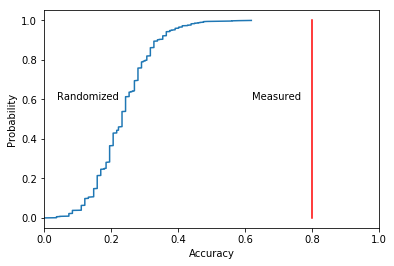

In [99]:
xvs.sort()
yvs = [(1.0*v) / len(xvs) for v in range(len(xvs))]
plt.plot(xvs, yvs, [0.8, 0.8], [0, 1], 'r')
plt.xlim(0, 1.0)
plt.xlabel("Accuracy")
plt.ylabel("Probability")
plt.text(0.62, 0.6, "Measured")
plt.text(0.04, 0.6, "Randomized")

**Notes**
1. Calculate a distribution of average accuracy for decorrelated data. Plot CDF and show where data lies with std.

# Effect of Fractional Decorrelations

Bug is that I'm sampling X but not keeping the associated Y.

In [29]:
def calcClassificationAccuracy(provider, frac):
    """
    :param float frac: fraction decorrelate
    :return float, float: mean, std of classification error
    """
    NUM_REPETITIONS = 5
    df_X = makeFeatureDF(provider)
    ser_Y = makeClassSer(provider)
    generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df_X)
    df = generator.synthesize(len(df_X), frac)
    xvs = []
    for _ in range(NUM_REPETITIONS):
        df_full
        generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df)
        df = generator.sample(len(df))
        clf = DecisionTreeClassifier(random_state=0)
        xvs.append(np.mean(cross_val_score(clf, df, ser_Y, cv=3)))
    return np.mean(xvs), np.std(xvs)

In [30]:
calcClassificationAccuracy(provider, 0.0)

(0.16825396825396827, 0.03451747392656104)

In [34]:
df_X = makeFeatureDF(provider)
ser_Y = makeClassSer(provider)
generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df_X)
df = generator.synthesize(len(df_X), 0)
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, df, ser_Y, cv=3)

array([0.11111111, 0.22222222, 0.        ])